In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ADS2002-Project-CatheterPlacement

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1sDmXQTrvwQhCF8mWDh9phnwM9axaYjjb/ADS2002-Project-CatheterPlacement


In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from PIL import Image
import ast
import os
import cv2

In [ ]:
train = pd.read_csv('Data/train.csv')
train.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [8]:
filenames = os.listdir("Data/train")
train_imgs = []
FileIDs = []
lst = []


desired_channels = 3

count = 0
for file in filenames:
    if count == 500:
        break

    # Making sure the images are the same pixel size
    img = Image.open(f"Data/train/{file}")
    img = img.resize((224, 224))
    img = np.array(img)

    # Ensure that the image has 3 channels (RGB)
    if img.shape[-1] != 3:
        img = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB by duplicating channels

    train_imgs.append(img)  # Append the 4D image to the list

    # Save filename for later
    FileIDs.append(file)

    count += 1

# Convert the list of images to a numpy array
train_imgs = np.array(train_imgs)

In [9]:
#extracting just the CVC labels
train_data = pd.read_csv("/content/drive/MyDrive/ADS2002-Project-CatheterPlacement/Data/train.csv")
CVC_train = train_data[["StudyInstanceUID","CVC - Abnormal", "CVC - Borderline", "CVC - Normal"]]
CVC_train.set_index('StudyInstanceUID', inplace=True)
CVC_train.head()

,CVC - Abnormal,CVC - Borderline,CVC - Normal
StudyInstanceUID,,,
1.2.826.0.1.3680043.8.498.26697628953273228189375557799582420561,0,0,0
1.2.826.0.1.3680043.8.498.46302891597398758759818628675365157729,0,0,1
1.2.826.0.1.3680043.8.498.23819260719748494858948050424870692577,0,1,0
1.2.826.0.1.3680043.8.498.68286643202323212801283518367144358744,1,0,0
1.2.826.0.1.3680043.8.498.10050203009225938259119000528814762175,0,0,1


In [10]:
CVC_train['CVC - Present'] = np.where((CVC_train['CVC - Abnormal'] == 0) & (CVC_train['CVC - Normal'] == 0) & (CVC_train['CVC - Borderline'] == 0), 0, 1)

<ipython-input-10-8abb49231a47>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CVC_train['CVC - Present'] = np.where((CVC_train['CVC - Abnormal'] == 0) & (CVC_train['CVC - Normal'] == 0) & (CVC_train['CVC - Borderline'] == 0), 0, 1)


In [11]:
CVC_train['CVC - Present'].value_counts()

1    29333
0      750
Name: CVC - Present, dtype: int64

In [12]:
#cleaning up the labels
UID = []
for i in range(len(FileIDs)):
  UID.append(FileIDs[i].replace(".jpg",""))

UID[0:10]

['1.2.826.0.1.3680043.8.498.96373614405512283046314488555604647941',
 '1.2.826.0.1.3680043.8.498.96315500926641444675409331764690933307',
 '1.2.826.0.1.3680043.8.498.96450515721778915344219421534269786290',
 '1.2.826.0.1.3680043.8.498.96255059007178680952242469330314808585',
 '1.2.826.0.1.3680043.8.498.96311228469094629679821868712032248786',
 '1.2.826.0.1.3680043.8.498.96359554498564333142663951388648557789',
 '1.2.826.0.1.3680043.8.498.96447675290915183668080373345495953473',
 '1.2.826.0.1.3680043.8.498.96279880013483713441521686300695558821',
 '1.2.826.0.1.3680043.8.498.96349754766067875463134738379718157835',
 '1.2.826.0.1.3680043.8.498.96258089029863343818062710263042584654']

In [13]:
train_labels = np.empty((0,3))
data = []

for ID in UID:
    data.append(CVC_train.loc[ID])

train_labels_df = pd.DataFrame(data)



train_labels_df = train_labels_df.reindex(UID)
train_labels = train_labels_df['CVC - Present'].values
# train_labels = train_labels_df.values
train_labels

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,

In [14]:
from sklearn.model_selection import train_test_split

# Split your data into training and temporary data (combined validation and test)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(train_imgs, train_labels, test_size=0.3, random_state=42)

# Split the temporary data into validation and test sets
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, random_state=42)

In [15]:
# Importing necessary libraries
from google.colab import drive
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [16]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 base model without its top layers
base_model = DenseNet121(weights='imagenet', include_top=False)

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling layer
x = Dense(1024, activation='relu')(x)  # Add a dense layer with ReLU activation
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Construct the full model
model = Model(inputs=base_model.input, outputs=predictions)


# during the first rounds of training.
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, None, None, 64)       9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

In [17]:
# Define the training parameters
epochs = 10
batch_size = 32
# Train the model
history = model.fit(train_imgs, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(val_imgs, val_labels),
                    verbose=1)


Epoch 1/10
11/11 [==============================] - 81s 7s/step - loss: 0.2947 - accuracy: 0.9314 - val_loss: 0.2587 - val_accuracy: 0.9733
Epoch 2/10
11/11 [==============================] - 78s 7s/step - loss: 0.2479 - accuracy: 0.9743 - val_loss: 0.2068 - val_accuracy: 0.9733
Epoch 3/10
11/11 [==============================] - 78s 7s/step - loss: 0.1540 - accuracy: 0.9743 - val_loss: 0.1144 - val_accuracy: 0.9733
Epoch 4/10
11/11 [==============================] - 77s 7s/step - loss: 0.1038 - accuracy: 0.9743 - val_loss: 0.1091 - val_accuracy: 0.9733
Epoch 5/10
11/11 [==============================] - 76s 7s/step - loss: 0.0984 - accuracy: 0.9743 - val_loss: 0.1051 - val_accuracy: 0.9733
Epoch 6/10
11/11 [==============================] - 77s 7s/step - loss: 0.0873 - accuracy: 0.9743 - val_loss: 0.0977 - val_accuracy: 0.9733
Epoch 7/10
11/11 [==============================] - 78s 7s/step - loss: 0.0801 - accuracy: 0.9743 - val_loss: 0.0954 - val_accuracy: 0.9733
Epoch 8/10
11/11 [==

In [18]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_imgs, test_labels, verbose=0)

print(f"Test accuracy: {accuracy * 100:.2f}%")


Test accuracy: 98.67%


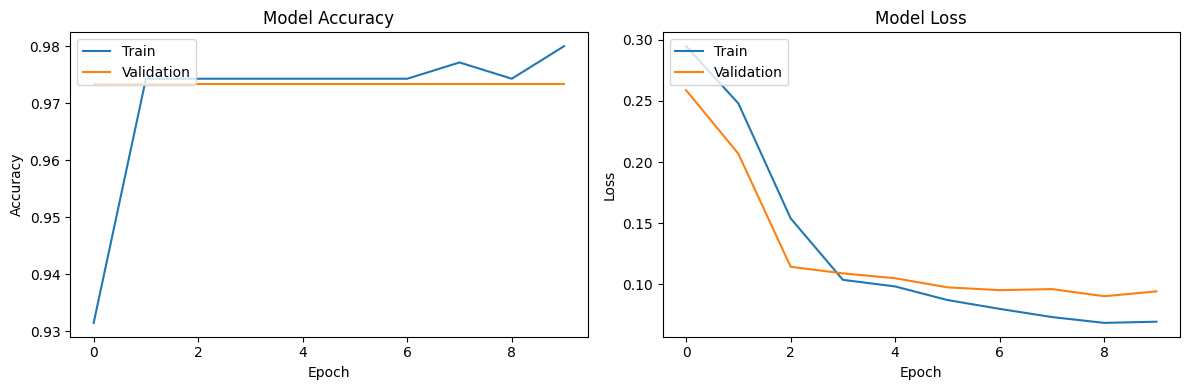

In [19]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [20]:

# Extract just the three CVC labels
new_labels = CVC_train[["CVC - Abnormal", "CVC - Borderline", "CVC - Normal"]]

# Ensure labels are aligned with the images based on StudyInstanceUID
new_labels = new_labels.loc[UID]

# Model Building
base_model = DenseNet121(weights='imagenet', include_top=False)  # Load DenseNet121 without top layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add custom fully connected layers
predictions = Dense(3, activation='softmax')(x)  # Output layer with softmax for multi-class classification

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Check if there are missing labels
missing_labels = train_imgs.shape[0] - new_labels.shape[0]

if missing_labels > 0:
    print(f"Warning: {missing_labels} image(s) have missing labels. Removing them.")
    train_imgs = train_imgs[:-missing_labels]
elif missing_labels < 0:
    print(f"Warning: {abs(missing_labels)} label(s) are missing corresponding images. Removing them.")
    new_labels = new_labels.iloc[:train_imgs.shape[0]]

# Split your data into training and temporary data (combined validation and test)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(train_imgs, new_labels, test_size=0.3, random_state=42)

# Split the temporary data into validation and test sets
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, random_state=42)

# Model Training
model.fit(train_imgs, train_labels, epochs=10, batch_size=32, validation_data=(val_imgs, val_labels))

# Model Evaluation
test_loss, test_accuracy = model.evaluate(test_imgs, test_labels)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')



Epoch 1/10
8/8 [==============================] - 235s 24s/step - loss: 1.1862 - accuracy: 0.5143 - val_loss: 0.8215 - val_accuracy: 0.6731
Epoch 2/10
8/8 [==============================] - 185s 23s/step - loss: 0.6942 - accuracy: 0.7714 - val_loss: 0.7813 - val_accuracy: 0.6538
Epoch 3/10
8/8 [==============================] - 189s 24s/step - loss: 0.4850 - accuracy: 0.8082 - val_loss: 0.7904 - val_accuracy: 0.6538
Epoch 4/10
8/8 [==============================] - 179s 22s/step - loss: 0.3691 - accuracy: 0.8898 - val_loss: 0.8166 - val_accuracy: 0.6346
Epoch 5/10
8/8 [==============================] - 178s 22s/step - loss: 0.4748 - accuracy: 0.8653 - val_loss: 0.9246 - val_accuracy: 0.6346
Epoch 6/10
8/8 [==============================] - 183s 23s/step - loss: 0.6130 - accuracy: 0.8735 - val_loss: 1.1853 - val_accuracy: 0.5769
Epoch 7/10
8/8 [==============================] - 181s 22s/step - loss: 0.8394 - accuracy: 0.8653 - val_loss: 1.4032 - val_accuracy: 0.6154
Epoch 8/10
8/8 [====

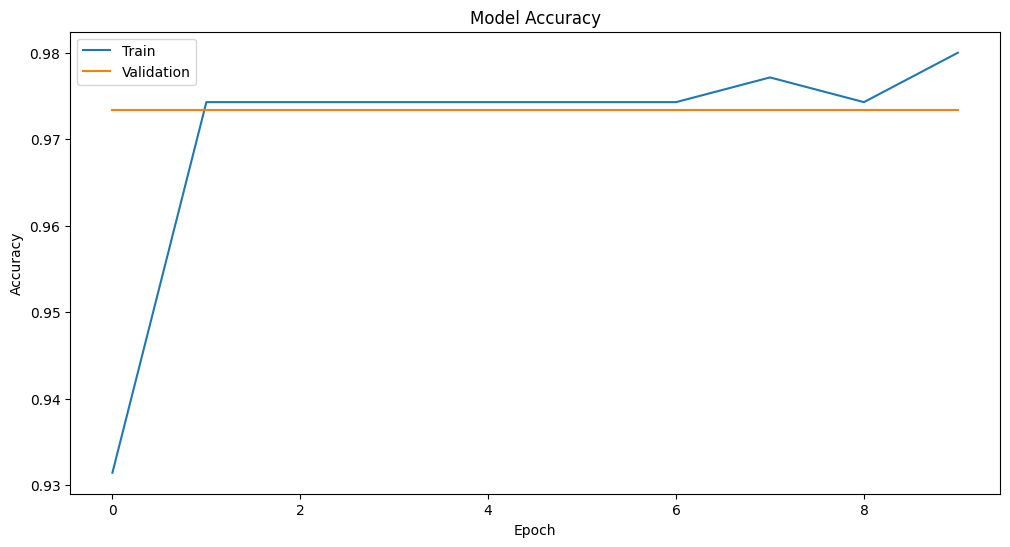

In [21]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
